In [2]:
import circgenerator as cg
from checksfinder import get_error_mitig_circ

from qiskit import QuantumCircuit, transpile, ClassicalRegister
# from qiskit_aer import AerSimulator
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit.providers.aer.noise import depolarizing_error, NoiseModel
from matplotlib import pyplot as plt

In [3]:
def simulate(circ, noise_model, num_shots):
    circ_with_measurement = circ.copy('circ_with_measurement')
    circ_with_measurement.measure_all()
    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(circ_with_measurement, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(circ_with_measurement)
    return count

In [4]:
def simulate_with_pcs(circ, noise_model, levels, num_shots):
    n_qubits = circ.num_qubits
    qem_qasm = get_error_mitig_circ(circ.qasm(), levels)
    qem_circ = QuantumCircuit.from_qasm_str(qem_qasm)
    
    crs = ClassicalRegister(n_qubits)
    qem_circ.add_register(crs)
    for i, qubit in enumerate(qem_circ.qubits[:n_qubits]):
        qem_circ.measure(qubit, crs[i])

    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(qem_circ, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(qem_circ)

    #post selection of results
    count_filtered = {}
    for i in count.keys():
        if i[n_qubits+1:] == '0'*levels:
            count_filtered[i[:n_qubits]]=count[i]
    
    return count_filtered

In [5]:
n_qubits=2
n_cnots = 2

rep = 3
# circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots, 0)
circ = QuantumCircuit(n_qubits)
for i in range(rep):
    circ.h(0)
    circ.cnot(0, 1)
    # circ.x(2)
print(circ)


     ┌───┐     ┌───┐     ┌───┐     
q_0: ┤ H ├──■──┤ H ├──■──┤ H ├──■──
     └───┘┌─┴─┐└───┘┌─┴─┐└───┘┌─┴─┐
q_1: ─────┤ X ├─────┤ X ├─────┤ X ├
          └───┘     └───┘     └───┘


In [6]:
dep_err_channel = depolarizing_error(0.3, 1)
noise_model_dep_err = NoiseModel()
noise_model_dep_err.add_all_qubit_quantum_error(dep_err_channel, 'h')
print(noise_model_dep_err)
num_shots = 10000

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h']
  All-qubits errors: ['h']


running...
searching...
terminating...
       ░                                                ┌───┐»
 a_0: ─░────────────────────────────────────────────────┤ X ├»
       ░      ┌───┐                                ┌───┐└─┬─┘»
 a_1: ─░──────┤ X ├────────────────────────────────┤ X ├──┼──»
       ░ ┌───┐└─┬─┘┌──────────────────────────────┐└─┬─┘  │  »
 b_0: ─░─┤ H ├──┼──┤ U3(1.0593e-13,3.2883,2.8116) ├──┼────┼──»
       ░ ├───┤  │  └──────────────────────────────┘  │    │  »
 b_1: ─░─┤ H ├──┼────────────────────────────────────■────■──»
       ░ ├───┤  │                                            »
 b_2: ─░─┤ H ├──■────────────────────────────────────────────»
       ░ └───┘                                               »
c0: 3/═══════════════════════════════════════════════════════»
                                                             »
«              ┌─────┐                                     ┌───┐┌───┐ ░ ┌───┐»
« a_0: ────────┤ Sdg ├─────────────────────────────────────┤ X 

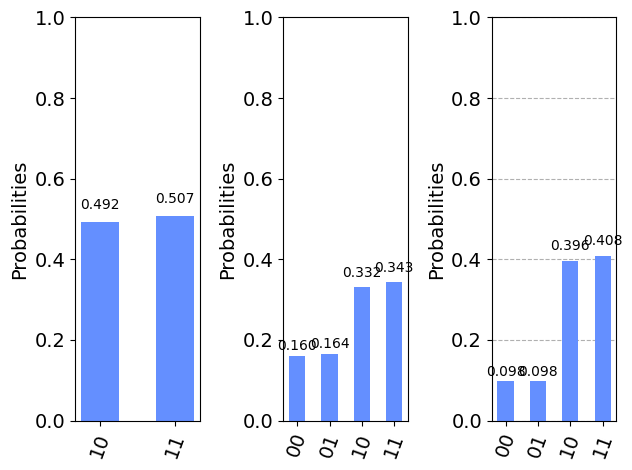

In [7]:
noise_model = noise_model_dep_err
count = simulate_with_pcs(circ, noise_model, 3, num_shots)
print(sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0])
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
plot_histogram(count, ax=axs[2])
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

In [10]:
dep_err_channel = depolarizing_error(0.5, 2)
print(dep_err_channel)
noise_model_dep_err_multi = NoiseModel()
noise_model_dep_err_multi.add_all_qubit_quantum_error(dep_err_channel, 'cx')
print(noise_model_dep_err_multi)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.53125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(II) │
q_1: ┤1           ├
     └────────────┘
  P(1) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IX) │
q_1: ┤1           ├
     └────────────┘
  P(2) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IY) │
q_1: ┤1           ├
     └────────────┘
  P(3) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IZ) │
q_1: ┤1           ├
     └────────────┘
  P(4) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XI) │
q_1: ┤1           ├
     └────────────┘
  P(5) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XX) │
q_1: ┤1           ├
     └────────────┘
  P(6) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XY) │
q_1: ┤1           ├
     └────────────┘
  P(7) = 0.03125, Circuit = 
     ┌────────────┐
q_0: ┤

running...
searching...
terminating...
       ░ ┌───┐                                     ┌───┐         ┌───┐         »
 a_0: ─░─┤ H ├─────────────────────────────────────┤ X ├─────────┤ H ├─────────»
       ░ └───┘┌───┐             ┌───┐              └─┬─┘┌────────┴───┴────────┐»
 a_1: ─░──────┤ X ├─────────────┤ H ├────────────────┼──┤ U3(π,5.8992,2.7576) ├»
       ░ ┌───┐└─┬─┘┌────────────┴───┴─────────────┐  │  └─────────────────────┘»
 b_0: ─░─┤ H ├──┼──┤ U3(1.0593e-13,3.2883,2.8116) ├──┼─────────────────────────»
       ░ ├───┤  │  └──────────────────────────────┘  │                         »
 b_1: ─░─┤ H ├──┼────────────────────────────────────┼─────────────────────────»
       ░ ├───┤  │  ┌──────────────────────────────┐  │                         »
 b_2: ─░─┤ H ├──┼──┤ U3(1.0593e-13,3.2883,2.8116) ├──┼─────────────────────────»
       ░ ├───┤  │  ├──────────────────────────────┤  │                         »
 b_3: ─░─┤ H ├──┼──┤ U3(1.0593e-13,3.2883,2.8116) ├──┼────────────────

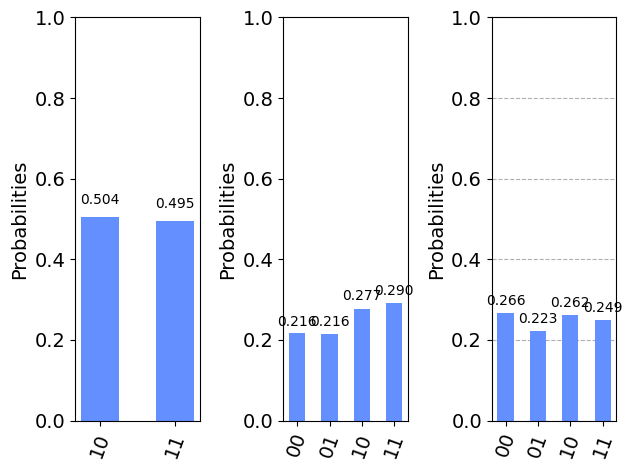

In [11]:
num_shots = 10000
noise_model = noise_model_dep_err_multi

count = simulate_with_pcs(circ, noise_model, 5, num_shots)
print(sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0])
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
plot_histogram(count, ax=axs[2])
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

In [12]:
n_qubits=2

rep = 1
# circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots, 0)
circ = QuantumCircuit(n_qubits)
for i in range(rep):
    # circ.h(0)
    circ.cnot(0, 1)
    # circ.x(2)
print(circ)

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘


running...
searching...
terminating...
        ░           ┌───┐ ░       ░ ┌───┐      ░    
  a_0: ─░───────────┤ X ├─░───■───░─┤ X ├──────░────
        ░      ┌───┐└─┬─┘ ░ ┌─┴─┐ ░ └─┬─┘      ░    
  a_1: ─░──────┤ X ├──┼───░─┤ X ├─░───┼────────░────
        ░ ┌───┐└─┬─┘  │   ░ └───┘ ░   │  ┌───┐ ░ ┌─┐
    b: ─░─┤ H ├──■────■───░───────░───■──┤ H ├─░─┤M├
        ░ └───┘           ░       ░      └───┘ ░ └╥┘
c12: 1/═══════════════════════════════════════════╩═
                                                  0 
total execution time 0.39162611961364746
done
0.5318


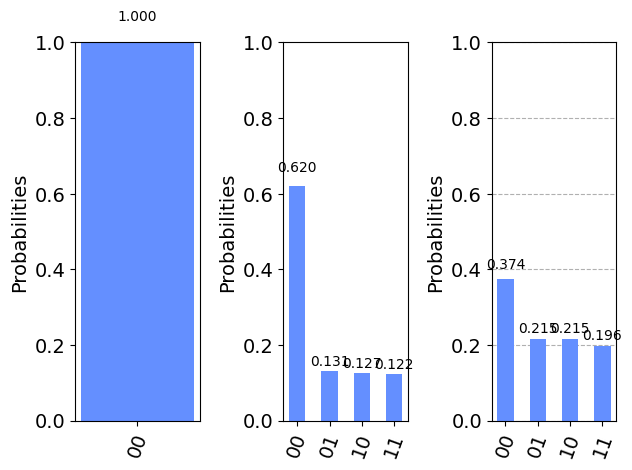

In [16]:
num_shots = 10000
noise_model = noise_model_dep_err_multi

count = simulate_with_pcs(circ, noise_model, 1, num_shots)
print(sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0])
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
plot_histogram(count, ax=axs[2])
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

In [32]:
n_qubits=2
n_cnots = 1

# rep = 3
circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots, 0)
# circ = QuantumCircuit(n_qubits)
# for i in range(rep):
#     circ.h(0)
#     circ.cnot(0, 1)
#     # circ.x(2)
print(circ)

        ┌───┐┌───┐┌───┐┌───┐     ┌─────┐┌───┐
q321_0: ┤ Z ├┤ S ├┤ H ├┤ S ├──■──┤ Sdg ├┤ H ├
        ├───┤└───┘└───┘└───┘┌─┴─┐├─────┤├───┤
q321_1: ┤ H ├───────────────┤ X ├┤ Sdg ├┤ H ├
        └───┘               └───┘└─────┘└───┘


running...
searching...
terminating...
        ░ ┌───┐                                     ┌───┐┌───┐»
  a_0: ─░─┤ H ├─────────────────────────────────────┤ X ├┤ H ├»
        ░ ├───┤┌───┐             ┌───┐              └─┬─┘├───┤»
  a_1: ─░─┤ H ├┤ X ├─────────────┤ H ├────────────────┼──┤ H ├»
        ░ ├───┤└─┬─┘┌────────────┴───┴─────────────┐  │  └───┘»
  b_0: ─░─┤ H ├──┼──┤ U3(1.0593e-13,3.2883,2.8116) ├──┼───────»
        ░ ├───┤  │  └──────────────────────────────┘  │       »
  b_1: ─░─┤ H ├──■────────────────────────────────────■───────»
        ░ └───┘                                               »
c22: 2/═══════════════════════════════════════════════════════»
                                                              »
«                                                                ┌───┐ ░ ┌───┐»
«  a_0: ─────────────────────────────────────────────────────────┤ X ├─░─┤ Z ├»
«       ┌─────────────────────┐┌───┐┌──────────────────────┐┌───┐└─┬─┘ ░ ├───┤»
«  a_1: ┤ U3(π,5.

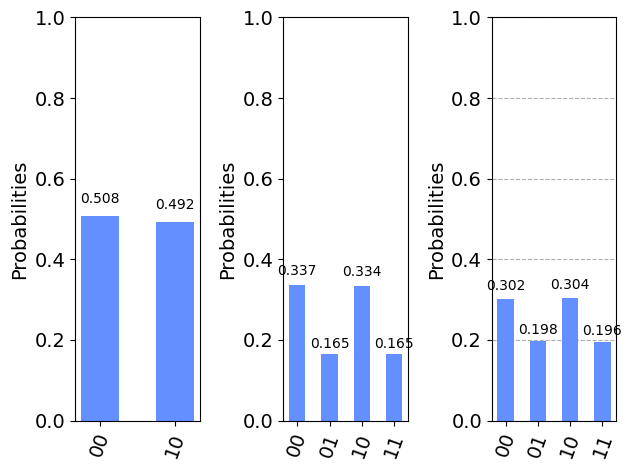

In [33]:

noise_model = noise_model_dep_err
count = simulate_with_pcs(circ, noise_model, 2, num_shots)
print(sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0])
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
plot_histogram(count, ax=axs[2])
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

For some random circuits, 1 Q depol error gives larger error after mitigation

In qiskit, depol applied error before the unitart which might be probamatic..
Try applying error after unitary as in the paper